Os incêndios florestais são um grave problema para a preservação das Florestas Tropicais. Compreender a frequência dos incêndios florestais em uma série temporal pode ajudar a tomar medidas para evitá-los.

Objetivo: Realizar a previsão de frequências de focos de incêndio para X dias.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from prophet import Prophet
import seaborn as sns
from sklearn.preprocessing import StandardScaler

/home/wolf/anaconda3/envs/ai_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Adquirindo os dados

**Download do dataset**

Fonte: [Banco de Dados de Queimadas](https://basedosdados.org/dataset/f06f3cdc-b539-409b-b311-1ff8878fb8d9?raw_data_source=894ea9e3-c94a-4c99-a022-171ce01ac6ff)

In [2]:
# !wget -O dataset_2022.zip https://dataserver-coids.inpe.br/queimadas/queimadas/focos/csv/anual/Brasil_todos_sats/focos_br_todos-sats_2022.zip
# !wget -O dataset_2023.zip https://dataserver-coids.inpe.br/queimadas/queimadas/focos/csv/anual/Brasil_todos_sats/focos_br_todos-sats_2023.zip
# !wget -O dataset_2024.zip https://dataserver-coids.inpe.br/queimadas/queimadas/focos/csv/anual/Brasil_todos_sats/focos_br_todos-sats_2024.zip

**Descompactando os dados**

Necessário instalar o unzip com:

```bash
    sudo apt-get install zip unzip
```

In [3]:
# !unzip dataset_2022.zip -d dataset/
# !unzip dataset_2023.zip -d dataset/
# !unzip dataset_2024.zip -d dataset/

## Análise exploratória dos dados

In [4]:
DATA_DIR_2022 = Path('dataset/focos_br_todos-sats_2022.csv')
DATA_DIR_2023 = Path('dataset/focos_br_todos-sats_2023.csv')
DATA_DIR_2024 = Path('dataset/tmp/focos_br_todos-sats_2024.csv')

df_2022 = pd.read_csv(DATA_DIR_2022, parse_dates=['data_pas']) # parse_dates converte o campo de data para um datetime
df_2023 = pd.read_csv(DATA_DIR_2023, parse_dates=['data_pas'])
df_2024 = pd.read_csv(DATA_DIR_2024, parse_dates=['data_pas'])

df = pd.concat([df_2022, df_2023, df_2024], # Junta os dataframes em um só
               ignore_index=True) # Reordena os índices após a concatenação, se necessário

df.head()

,latitude,longitude,data_pas,satelite,pais,estado,municipio,bioma,numero_dias_sem_chuva,precipitacao,risco_fogo,id_area_industrial,frp
0,-11.4152,-56.389099,2022-05-13 01:34:50,METOP-B,Brasil,MATO GROSSO,TABAPORÃ,Amazônia,14.0,5.1,0.1,0,NaN
1,-11.4132,-56.380798,2022-05-13 01:34:50,METOP-B,Brasil,MATO GROSSO,TABAPORÃ,Amazônia,15.0,5.7,0.1,0,NaN
2,-11.4327,-56.375999,2022-05-13 01:34:49,METOP-B,Brasil,MATO GROSSO,TABAPORÃ,Amazônia,15.0,4.9,0.1,0,NaN
3,-11.7623,-56.591202,2022-05-13 01:34:45,METOP-B,Brasil,MATO GROSSO,PORTO DOS GAÚCHOS,Amazônia,20.0,0.9,0.2,0,NaN
4,-11.7720,-56.588902,2022-05-13 01:34:45,METOP-B,Brasil,MATO GROSSO,PORTO DOS GAÚCHOS,Amazônia,20.0,0.9,0.2,0,NaN


Removendo do dataset dados com o campo "numero_dias_sem_chuva" negativos, pois não faz sentido.

In [5]:
df = df.query('numero_dias_sem_chuva >= 0')

In [6]:
df.info(show_counts=True) # Show_counts exibe a quantidade de dados não nulos e tipos das colunas

<class 'pandas.core.frame.DataFrame'>
Index: 17010183 entries, 0 to 17411565
Data columns (total 13 columns):
 #   Column                 Non-Null Count     Dtype         
---  ------                 --------------     -----         
 0   latitude               17010183 non-null  float64       
 1   longitude              17010183 non-null  float64       
 2   data_pas               17010183 non-null  datetime64[ns]
 3   satelite               17010183 non-null  object        
 4   pais                   17010183 non-null  object        
 5   estado                 17010183 non-null  object        
 6   municipio              17010183 non-null  object        
 7   bioma                  17010160 non-null  object        
 8   numero_dias_sem_chuva  17010183 non-null  float64       
 9   precipitacao           17010183 non-null  float64       
 10  risco_fogo             17010183 non-null  float64       
 11  id_area_industrial     17010183 non-null  int64         
 12  frp              

In [7]:
df.describe()

,latitude,longitude,data_pas,numero_dias_sem_chuva,precipitacao,risco_fogo,id_area_industrial,frp
count,1.701018e+07,1.701018e+07,17010183,1.701018e+07,1.701018e+07,1.701018e+07,1.701018e+07,1.587153e+07
mean,-9.664868e+00,-5.280730e+01,2023-11-22 13:49:30.005427456,2.704346e+01,7.415802e-01,-8.728453e+00,1.266830e-01,3.862381e+01
min,-3.341841e+01,-7.386338e+01,2022-01-01 00:03:00,0.000000e+00,0.000000e+00,-9.990000e+02,0.000000e+00,-3.800000e+00
25%,-1.261861e+01,-5.754807e+01,2022-12-01 05:12:00,4.000000e+00,0.000000e+00,5.300000e-01,0.000000e+00,3.800000e+00
50%,-9.030000e+00,-5.261120e+01,2023-11-18 03:46:43,1.000000e+01,0.000000e+00,9.900000e-01,0.000000e+00,1.020000e+01
75%,-6.204385e+00,-4.702992e+01,2024-09-01 17:28:00,3.500000e+01,0.000000e+00,1.000000e+00,0.000000e+00,5.700000e+01
max,5.217610e+00,-3.505485e+01,2024-12-31 23:50:00,3.590000e+02,2.529800e+02,1.000000e+00,3.460000e+02,8.094300e+03
std,5.612614e+00,7.243545e+00,NaN,3.483289e+01,3.709542e+00,9.692822e+01,5.748884e+00,7.126380e+01


In [8]:
# Cria um novo campo apenas com a data, sem a hora
df['data'] = df['data_pas'].dt.date

# Adquire o nome do mês em string
df['mes'] = df['data_pas'].dt.month_name()

# Adquire o ano
df["ano"] = df["data_pas"].dt.year
df["ano_normalizado"] = df["ano"] - df["ano"].min() # Irá criar uma variável numérica como 1,2,3 dependendo do ano

In [9]:
df_occurrences = df.groupby('data').size().reset_index(name='ocorrencias')
df_occurrences.head()

,data,ocorrencias
0,2022-01-01,1025
1,2022-01-02,1213
2,2022-01-03,1412
3,2022-01-04,1876
4,2022-01-05,1760


### Visualizando a frequência de ocorrências ao longo dos anos (em dias)

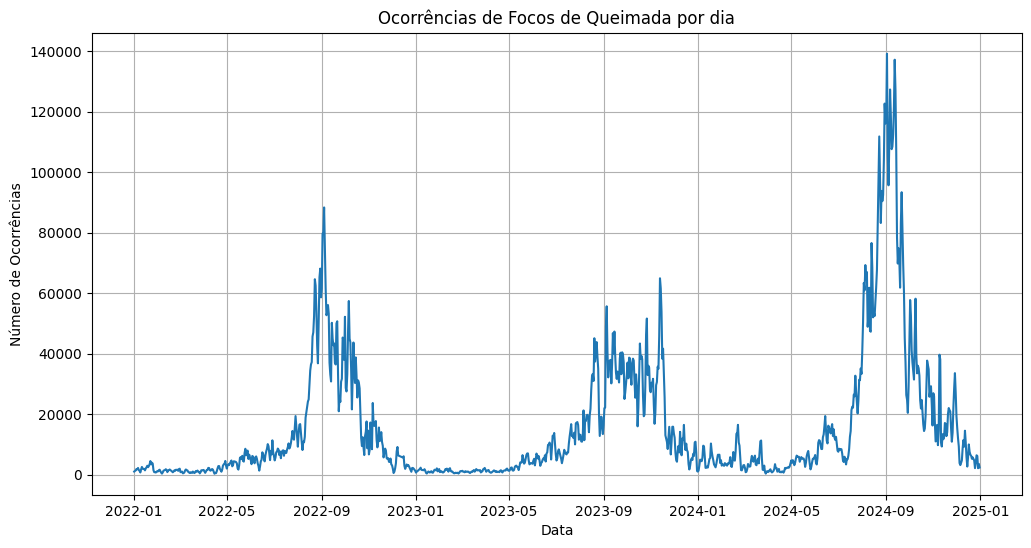

In [10]:
plt.figure(figsize=(12,6))
plt.plot(df_occurrences['data'], df_occurrences['ocorrencias'])
plt.title('Ocorrências de Focos de Queimada por dia')
plt.xlabel('Data')
plt.ylabel('Número de Ocorrências')
plt.grid(True)

## Pré processando os dados

### Agrupando dados por bioma, mês e ano

In [11]:
df_occurrences_month = df.groupby(['bioma', 'mes', 'ano_normalizado']).agg({ # Agg realiza calculos nas colunas
    'precipitacao': 'mean', # Média da precipitação
    'numero_dias_sem_chuva': lambda x: round(x.mean()), # Média do número de dias sem chuva e arredonda para o número mais próximo
    'pais': 'count' # Utilizando qualquer coluna para fazer a contagem de ocorrências
}).rename(columns={
    'precipitacao': 'media_precipitacao',
    'numero_dias_sem_chuva': 'media_dias_sem_chuva',
    'pais': 'ocorrencias' # Renomeando a coluna "pais" (count) para "ocorrencias"
}).reset_index() # Remove os índices hierárquicos para colunas normais do dataframe

df_occurrences_month.head()

,bioma,mes,ano_normalizado,media_precipitacao,media_dias_sem_chuva,ocorrencias
0,Amazônia,April,0,0.825760,4,13847
1,Amazônia,April,1,2.128289,6,11133
2,Amazônia,April,2,1.763923,4,18907
3,Amazônia,August,0,0.566177,18,676502
4,Amazônia,August,1,1.574155,11,447178


### Realizando o one-hot encoding das variáveis categóricas bioma e mês

In [24]:
dummies = pd.get_dummies(df_occurrences_month, columns=['bioma', 'mes'])
df_final = pd.concat([df_occurrences_month[['bioma', 'mes']], dummies], axis=1)

In [25]:
df_final = df_final.drop(['bioma','mes'], axis=1)
df_final.head()

,ano_normalizado,media_precipitacao,media_dias_sem_chuva,ocorrencias,bioma_Amazônia,bioma_Caatinga,bioma_Cerrado,bioma_Mata Atlântica,bioma_Pampa,bioma_Pantanal,...,mes_December,mes_February,mes_January,mes_July,mes_June,mes_March,mes_May,mes_November,mes_October,mes_September
0,0,0.825760,4,13847,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,2.128289,6,11133,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2,1.763923,4,18907,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,0.566177,18,676502,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1,1.574155,11,447178,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Analisando a correlação entre as variáveis

In [26]:
corr = df_final.corr(numeric_only=True)

<Axes: >

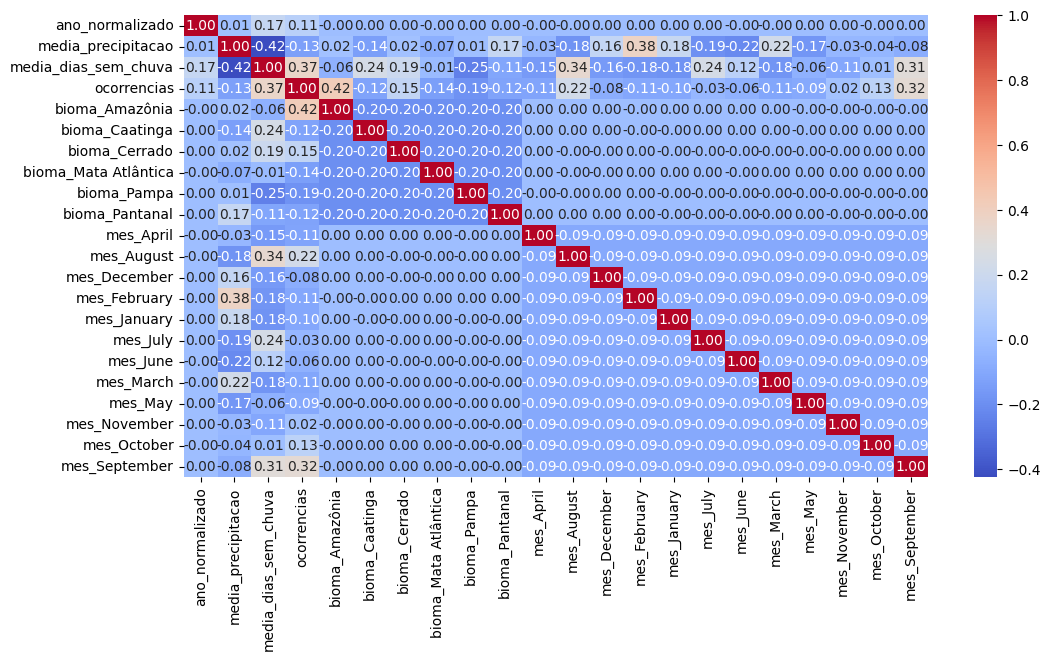

In [27]:
plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')

Há algumas correlações positivas interessantes com a variável alvo (ocorrências), dentre elas:

Mês de **Setembro** (0.32), **Agosto** (0.22) e **Outubro** (0.13), onde ocorrem mais focos de incêndio, ou seja, ocorrência é maior nesses meses.

Assim como, também é possível observar outras correlações positivas além dos meses que influenciam a variável ocorrência ser maior, como a **média dos dias sem chuva** (0.37), pertencer ao bioma **Amazônia** (0.42) ou **Cerrado** (0.15), 

In [ ]:
# TODO: Verificar como é possível adquirir o número máximo de incêndio para cada bioma por mês
# Para fazer isso:
# limite = df.groupby("bioma")["focos_detectados"].quantile(0.95) 
# risco = min(predicao / LIMITE, 1.0) * 100

# Antes será necessário realizar o groupBy por bioma e mês
# Adquirir a somatória dos focos
# Por fim, realizar o quantile (pega o maior número baseado no quantil 95%)
# Talvez disponibilizar um CSV com esses máximos para realizar o cálculo após a predição

# Esse percentual será baseado em uma análise dos dados (por exemplo, o percentil 95 da distribuiçao de focos por bioma/mês)

In [ ]:
# TODO: Realizar a normalização ou padronização dos dados

# Talvez não será necessário a coluna ano para predição (?) E talvez nem para treinamento (?)
# Pois os dados já foram agrupados por ano, mês e bioma, então não seria necessário manter essa coluna (?)

In [ ]:
# TODO: Testar modelos random forest (com validação cruzada) e redes neurais recorrentes